# Transfer Learning: Scale Up the Previous Task (with a larger set of data)

## Introduction
In this notebook we will be trying to take advantage of those previously learned techniques (feature extraction & fine-tuning) while scaling up the data with **Food vision mini** trying to beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data and trying to see how they go with the full 101 Food Classes. Once again, this tutorial is mainly inspired by **Daniel Bourke**'s work.

**NOTE!** We have all learned by now that This is a common practice in machine learning and deep learning is to get a model working on a small amount of data before scaling it up to a larger amount of data.

Old habits die hard, right? So let us first check GPU availability!

In [2]:
!nvidia-smi

Fri Oct 24 13:51:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-10-24 13:51:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-10-24 13:51:41 (12.2 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [4]:
# Import the necessary functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [5]:
# Download and preprocess data (data is actually preprocessed and prepared earlier)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-10-24 13:51:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   100MB/s    in 10s     

2025-10-24 13:52:02 (154 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In case you are also interested in learning further about how the data is preprocessed, see the notebook [Image Data Preprocessing](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

In [6]:
# Walk through directories to understand how it is basically structured
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/grilled_cheese_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images i

```
10_food_classes_10_percent/          <- parent directory
├── train                            <- training images
│   ├── pizza
│   │   │   1647351.jpg
│   │   │   1647352.jpg
│   │   │   ...
│   └── steak
│       │   1648001.jpg
│       │   1648050.jpg
│       │   ...
│
└── test                             <- testing images
    ├── pizza
    │   │   1001116.jpg
    │   │   1507019.jpg
    │   │   ...      
    └── steak
        │   100274.jpg
        │   1653815.jpg
        │   ...
```

As before, given the directory structure above, we will use `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a **TensorFlow datatype** which allows for us to pass the data paths (test & train) to our model directly.

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't (have to!) shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model on 10% of 101-class food dataset (via Transfer Learning)

To keep our experiments efficient, we’ll begin with feature extraction transfer learning using a pre-trained model for a few epochs, followed by a few additional epochs of fine-tuning.

The steps to take will be as follows:
- A `ModelCheckpoint` callback to save our progress during training
- Data augmentation built into the model
- Deploying `EfficientNetB0` architecture as our base model from `tf.keras.applications` leaving out the top layer (the head).
- A `Dense` layer with 101 hidden neurons and **Softmax Activation** as the output layer
- Categorical crossentropy as the loss function (multi-class task)
- Integrate **Adam Optimizer**
- Fitting for 5 full passes on the training data while evaluating on 15% of the test data

Let's start by creating the ModelCheckpoint callback. Remember it is important to apply the extension to the checkpoint name adding `.weights.h5`.

In [7]:
# Create checkpoint callback to save model for later use
chckpnt_pth = "101_classes_10_percent_data_model_checkpoint.weights.h5"
chckpnt_clbck = tf.keras.callbacks.ModelCheckpoint(
                                          chckpnt_pth,
                                          save_weights_only=True, # save only the model weights
                                          monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                          save_best_only=True) # only keep the best model weights on file (delete the rest)

In [8]:
# Import the required modules
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## OLD
# # Setup data augmentation
# from tensorflow.keras.layers.experimental import preprocessing
# data_augmentation = Sequential([
#   preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
#   preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
#   preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
#   preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
#   preprocessing.RandomZoom(0.2), # randomly zoom into an image
#   # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

We can include the `data_augmentation` Sequential model directly as a layer within our Functional API model. This ensures that if we resume training later, data augmentation will already be integrated into the pipeline.

Now we’ll load the base model with the argument `include_top=False`, allowing us to attach our own custom output layers — specifically, a `GlobalAveragePooling2D()` layer (to condense the base model’s outputs into a format suitable for the output layer), followed by a `Dense` layer.

In [9]:
# Setup base model and freeze its layers (the base model acts as a feature extractor)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Get a summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling          │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Time to compile and fit the model passing through the five layers structured and implemented.

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
his_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[chckpnt_clbck]) # save best model weights to file

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 169ms/step - accuracy: 0.1588 - loss: 3.9598 - val_accuracy: 0.4431 - val_loss: 2.5487
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - accuracy: 0.4736 - loss: 2.3403 - val_accuracy: 0.4960 - val_loss: 2.1098
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 156ms/step - accuracy: 0.5464 - loss: 1.9104 - val_accuracy: 0.5244 - val_loss: 1.9055
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.6038 - loss: 1.6842 - val_accuracy: 0.5344 - val_loss: 1.8237
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.6178 - loss: 1.5417 - val_accuracy: 0.5442 - val_loss: 1.7723


In [12]:
# Evaluate model on test data
res_feature_extraction_model = model.evaluate(test_data)
res_feature_extraction_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step - accuracy: 0.5514 - loss: 1.7139


[1.6011085510253906, 0.5769504904747009]

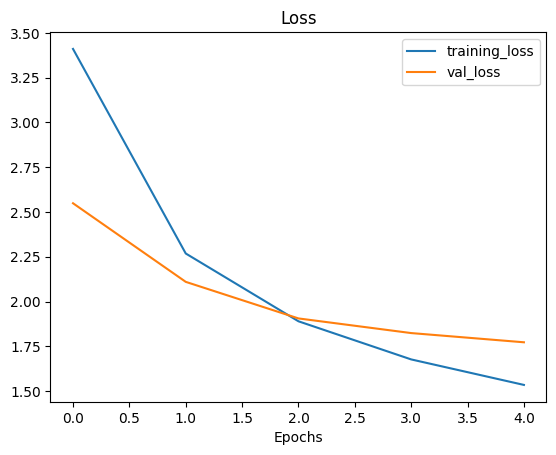

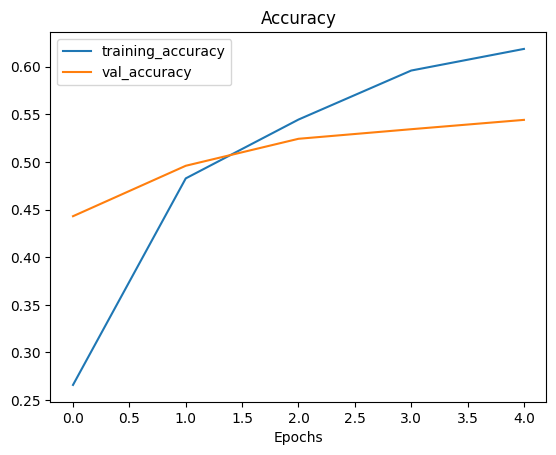

In [13]:
# Plot the results
plot_loss_curves(his_all_classes_10_percent)

### Fine-tuning Some Layers in the Base Model

To achieve better results, why don't we try to fine-tune a few top layers of the base model and evaluate the impact on model's performance.

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

**IMPORTANT NOTE!**: When fine-tuning and unfreezing the layers of a pre-trained model, it’s standard practice to reduce the learning rate compared to what was used during feature extraction. By how much? Typically, starting with a learning rate about 10 times lower is a good rule of thumb.

But why is that? To avoid destroying pre-trained weights (catastrophic forgetting).

In [15]:
# Recompile model with a lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [17]:
# Check which layers in the base model are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

Ready to fine-tune? Let us start from the last checkpoint and fine-tune for 5 more epochs.

In [18]:
fine_tune_more_epochs = 10 # total number of epochs (5 previously * 5 new)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_more_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=his_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.6284 - loss: 1.5446 - val_accuracy: 0.5694 - val_loss: 1.6965
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 154ms/step - accuracy: 0.6737 - loss: 1.3192 - val_accuracy: 0.5749 - val_loss: 1.6462
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.6892 - loss: 1.2460 - val_accuracy: 0.5832 - val_loss: 1.6143
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.7021 - loss: 1.1852 - val_accuracy: 0.5895 - val_loss: 1.5938
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.7211 - loss: 1.1090 - val_accuracy: 0.5898 - val_loss: 1.5757
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - accuracy: 0.7322 - loss: 1.0546 - val_accuracy: 0.5850 - val_loss: 1.5907


In [19]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_ft = model.evaluate(test_data)
results_all_classes_10_percent_ft

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 75ms/step - accuracy: 0.5995 - loss: 1.5151


[1.4161652326583862, 0.6199207901954651]

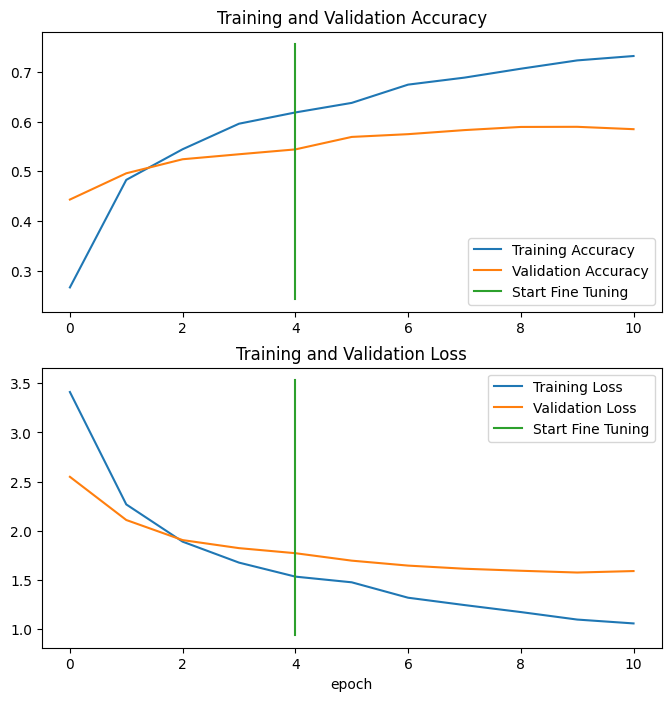

In [20]:
compare_historys(original_history=his_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

Observations?

After fine-tuning, our training metrics improved notably, but validation gains were limited — a sign of overfitting. This is common when the pre-trained model’s data is similar to the custom dataset. Since EfficientNetB0 was trained on ImageNet, which already includes many food images, feature extraction performs well, and fine-tuning brings smaller improvements.

In [21]:
# # Save model so it can be used later (you can also save to drive if connected)
# model.save("drive/My Drive/tensorflow_tutorial/101_food_class_10_percent_saved_big_dog_model")
model.save("101_food_class_10_percent_saved_big_dog_model.keras")


# OR alternatively
# import keras.saving as save
# save.save_model(model, "drive/My Drive/tensorflow_tutorial/101_food_class_10_percent_saved_big_dog_model.h5")

## Make Predictions with Our Trained Model

In [22]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 75ms/step


Let's make some predictions passing the test data - which the model has not seen before during training. This will then return the probabilities tensor.

In [23]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1)
len(pred_probs)

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 73ms/step


25250

How do you think it looks like?

In [24]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [3.1631616e-01 3.8998711e-04 2.5926590e-01 1.9555018e-06 4.3851443e-05
 9.7079264e-06 3.6906818e-04 4.2266744e-05 3.2678526e-02 1.9665001e-04
 4.0920904e-06 1.1387294e-05 3.5697005e-03 3.8243220e-06 9.8580597e-03
 3.3182781e-03 9.5819101e-05 1.9403321e-03 2.9074633e-03 1.2555013e-05
 1.8160177e-03 7.4170188e-05 7.6745503e-04 8.8519778e-04 1.5001786e-03
 1.3602312e-03 9.2299160e-04 2.3455394e-04 1.7331816e-02 1.9670245e-03
 2.1309861e-05 1.9239302e-03 3.3451949e-04 1.2944229e-05 6.8335952e-03
 2.4457147e-05 8.8763627e-04 2.9698254e-03 1.2929767e-02 8.8715256e-05
 1.9692571e-03 3.7004673e-03 4.9164641e-04 3.3301712e-05 5.4227287e-04
 5.0467217e-05 8.3349535e-04 4.2791326e-05 1.6420581e-05 1.9119652e-02
 1.2062505e-04 3.1587228e-04 6.6875786e-02 2.9041575e-02 1.8360266e-04
 1.5398225e-02 9.8423222e-03 5.1923851e-03 6.9982433e-03 5.0708193e-05
 9.6273461e-06 3.2260185e-03 7.9335151e-03 2.

One can simply find the index of the maximum value in each prediction probability tensor using the `argmax()` method.

In [25]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0, 38,  8, 78, 29,  0,  2,  0])

Our `test_data` object is in the form of a `tf.data.Dataset`, right?
What about we have a closer look into the test data using the `unbatch()` method through which we can explore images and labels separately. That is, we can have access to the images and labels in the test dataset. **Remember** that each element (batch) in `tf.data.Dataset` object is a tuple. That is, when we create a dataset through `tf.keras.preprocessing.image_dataset_from_directory`, this returns a `tf.data.Dataset` object, where each element (batch) is a tuple.

Having said all the above, let us see what are some techniques to iterate over such a dataset object.

**How can we investigate/iterate over a dataset?**

To look at a single batch, you can simply do:

In [45]:
# 1. Take the first batch and iterate over it
for images, labels in test_data.take(1):
    print(images.shape)
    print(labels)


(32, 224, 224, 3)
tf.Tensor(
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(32, 101), dtype=float32)


In [ ]:
# 2. Take a random batch and iterate over it
shuffled_ds = test_data.shuffle(buffer_size=1000)  # adjust buffer_size as needed
images, labels = next(iter(shuffled_ds.take(1)))  # randomly sampled batch

print(images.shape)
print(labels)

In [38]:
images, labels = iter(test_data.unbatch().numpy())

AttributeError: '_UnbatchDataset' object has no attribute 'numpy'

**IMPORTANT NOTE!** Since the labels are in one-hot encoded format, we'll use the `argmax()` method to return the index of the label.